In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lim_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lim_date_year = func.strftime("%Y-%m-%d",lim_date)
lim_date_year = lim_date_year-dt.timedelta(days=365)
lim_date_year

In [11]:
# Calculate the date 1 year ago from the last data point in the database
lim_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(lim_date)

('2017-08-23',)


In [12]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).filter(func.strftime("%Y-%m-%d",Measurement.date)>="2016-08-24")

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation = pd.DataFrame(precipitation,columns = ['date','prcp']).set_index('date').sort_index()
precipitation = precipitation.dropna()
precipitation

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00
2016-08-25,0.06


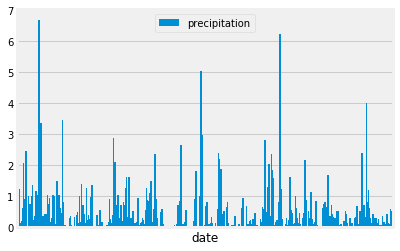

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation.plot.bar(width = 8)
plt.xticks([])
plt.grid(True, which ='major', axis ='x')
plt.legend(['precipitation'], loc ='upper center')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = [
    Measurement.station,
    func.count(Measurement.tobs)]

# List the stations and the counts in descending order.
session.query(*active_stations).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_stations = [
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
]
session.query(*active_stations).filter(Measurement.station == "USC00519281").first()

(54.0, 85.0, 71.66378066378067)

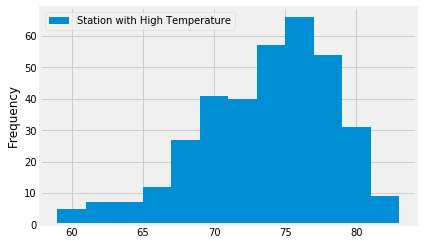

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_hightemp = pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.station=="USC00519281").filter(func.strftime("%Y-%m-%d",Measurement.date)>="2016-08-19").order_by(Measurement.date.desc()).all())
station_hightemp.hist(bins=12)
plt.ylabel("Frequency")
plt.title("")
plt.legend(["Station with High Temperature"])

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = '2019-02-02 to \n 2019-02-16'
trip_startdate = '2018-02-02'
trip_enddate = '2018-02-16'
trip_temps = calc_temps(trip_startdate, trip_enddate)
trip_temps

[(None, None, None)]

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_trip_temps = trip_temps[0][0]
avg_trip_temps = trip_temps[0][1]
max_trip_temps = trip_temps[0][2]

min_error = avg_trip_temps - min_trip_temps
max_error = max_trip_temps - avg_trip_temps

error_bars = np.array([[min_error], [max_error]])

plt.bar(trip, avg_trip_temps, yerr=error_bars, color = 'green', alpha = .5)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Average Temperature')
plt.ylabel('Temperature (F)')
plt.grid(alpha=.5)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

station_rain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_startdate)
                   .filter(Measurement.date <= trip_enddate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())
station_rain_table = pd.DataFrame(np.array(station_rain))
station_rain_table = station_rain_table.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})
station_rain_table

,Station


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
